<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Project Title: Paraphrase Classification Using XLNet-FineTuning</b></h1>



### Tabel of Contents:



* [Import Libraries](#1)

* [Load Dataset](#2)

* [XLNet Model](#4)

* [Evaluation](#3)

* [Predictive for Test](#8)

* [Like this? Upvote and comment! 🌊 End](#6)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Import Libraries</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [44]:
!pip install datasets

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, Dataset
from transformers import XLNetTokenizer,XLNetForSequenceClassification,Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
from nltk.corpus import stopwords
import re
import nltk
from huggingface_hub import login
import wandb
wandb.init(mode = "disabled")
import warnings
warnings.filterwarnings('ignore')

**<a id="2"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Load Dataset</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [46]:
# Load the PAWS dataset
dataset = load_dataset("glue", "mrpc")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [47]:
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
validation_df = pd.DataFrame(dataset['validation'])
train_df.head()

,sentence1,sentence2,label,idx
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1,0
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0,1
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1,2
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0,3
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1,4


In [48]:
test_df.head()

,sentence1,sentence2,label,idx
0,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...,1,0
1,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...,1,1
2,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...,1,2
3,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...,0,3
4,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...,0,4


In [49]:
validation_df.head()

,sentence1,sentence2,label,idx
0,He said the foodservice pie business doesn 't ...,""" The foodservice pie business does not fit ou...",1,9
1,Magnarelli said Racicot hated the Iraqi regime...,"His wife said he was "" 100 percent behind Geor...",0,18
2,"The dollar was at 116.92 yen against the yen ,...","The dollar was at 116.78 yen JPY = , virtually...",0,25
3,The AFL-CIO is waiting until October to decide...,The AFL-CIO announced Wednesday that it will d...,1,32
4,No dates have been set for the civil or the cr...,No dates have been set for the criminal or civ...,0,33


In [50]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
validation_dataset = Dataset.from_pandas(validation_df)
train_dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

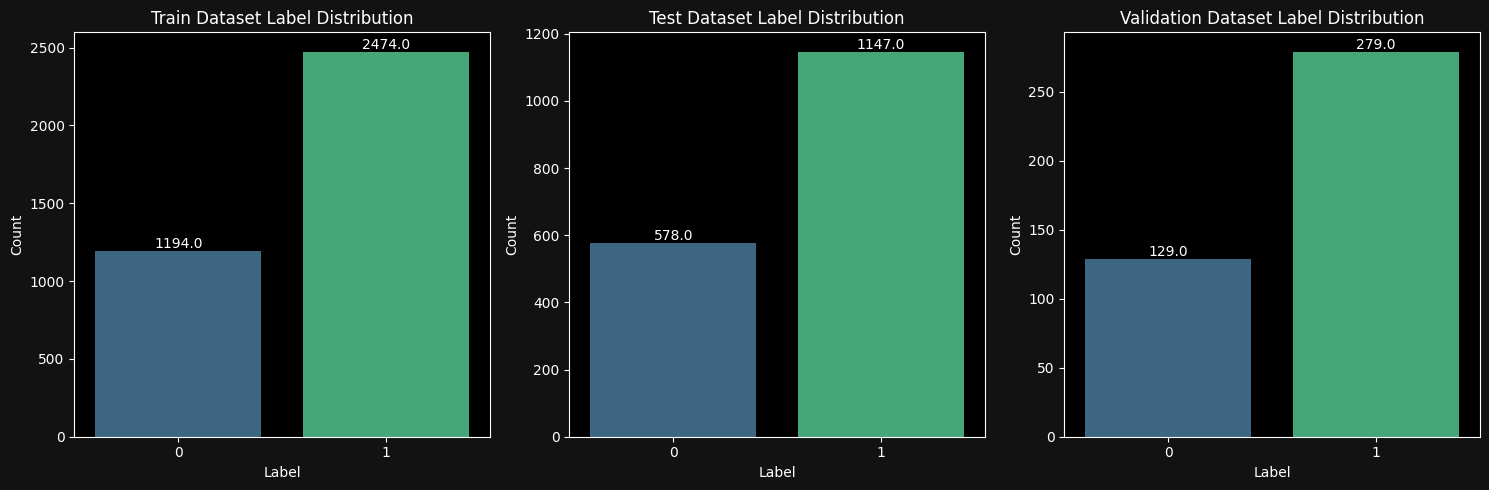

In [51]:
plt.figure(figsize=(15, 5), facecolor='#121212')
plt.style.use('dark_background')
# Create subplots
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=train_df, palette="viridis")
plt.title('Train Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=test_df, palette="viridis")
plt.title('Test Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=validation_df, palette="viridis")
plt.title('Validation Dataset Label Distribution')
plt.xlabel("Label")
plt.ylabel("Count")
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                   textcoords='offset points')
plt.tight_layout()
plt.show()

In [52]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def cleaning(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r'\r\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
    text = text.split()
    text = [w for w in text if not w in stop_words]
    text = " ".join(text)
    return text
# Apply cleaning function =
#train_dataset , test_dataset , validation_dataset = train_dataset.to_pandas() , test_dataset.to_pandas() , validation_dataset.to_pandas()
#train_dataset['sentence1'] = train_dataset['sentence1'].apply(cleaning)
#test_dataset['sentence1'] = test_dataset['sentence1'].apply(cleaning)
#validation_dataset['sentence2'] = validation_dataset['sentence2'].apply(cleaning)
#train_dataset = Dataset.from_pandas(train_dataset)
#test_dataset = Dataset.from_pandas(test_dataset)
#validation_dataset = Dataset.from_pandas(validation_dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="4"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">XLNET Model</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [53]:
# Initialize tokenizer and model
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
max_length = max([len(tokenizer.encode(sen1,sen2)) for sen1,sen2 in zip(train_dataset['sentence1'],train_dataset['sentence2'])])
max_length

141

In [55]:
# Tokenization function
def tokenize_function(examples):
    # Tokenize sentence1 and sentence2
    model_inputs = tokenizer(examples['sentence1'], examples['sentence2'], max_length=max_length ,truncation=True, padding="max_length")
    model_inputs['labels'] = examples['label']
    return model_inputs
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
print(train_dataset[0])

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0, 'input_ids': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2809, 986, 2928, 1739, 45, 1407, 17, 19, 1629, 43, 271, 17, 12, 18, 4936, 17, 12, 17, 19, 20, 12385, 31699, 56, 45, 1155, 17, 9, 4, 23895, 56, 22, 103, 34, 114, 17, 12, 18, 4936, 17, 12, 17, 19, 2809, 986, 2928, 1739, 45, 1407, 20, 12385, 31699, 56, 45, 1155, 17, 9, 4, 3], 'token_type_ids': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [56]:
# Define a metric computation function
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "f1": f1}
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./Finetuning_XLNET_Paraphrase_Classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)
# Define Trainer with metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics
)

In [57]:
trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.427370,0.825980,0.812605
2,0.509900,0.334658,0.857843,0.854733
3,0.327100,0.560697,0.875000,0.870974
4,0.229700,0.723839,0.870098,0.870232
5,0.134600,0.747819,0.877451,0.877702


In [58]:
tokenizer.save_pretrained(training_args.output_dir)

('./Finetuning_XLNET_Paraphrase_Classification/tokenizer_config.json',
 './Finetuning_XLNET_Paraphrase_Classification/special_tokens_map.json',
 './Finetuning_XLNET_Paraphrase_Classification/spiece.model',
 './Finetuning_XLNET_Paraphrase_Classification/added_tokens.json')

In [ ]:
login(token="HUGGINGFACE_TOKEN")

In [60]:
repo_name = "ahmed792002/Finetuning_XLNET_Paraphrase_Classification"
trainer.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

events.out.tfevents.1733347944.f9e6f9f039cb.734.3:   0%|          | 0.00/457 [00:00<?, ?B/s]

events.out.tfevents.1733349148.f9e6f9f039cb.11142.0:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

events.out.tfevents.1733348346.f9e6f9f039cb.734.4:   0%|          | 0.00/6.76k [00:00<?, ?B/s]

events.out.tfevents.1733350160.f9e6f9f039cb.11142.1:   0%|          | 0.00/7.49k [00:00<?, ?B/s]

Upload 7 LFS files:   0%|          | 0/7 [00:00<?, ?it/s]

events.out.tfevents.1733350657.f9e6f9f039cb.11142.2:   0%|          | 0.00/8.43k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ahmed792002/Finetuning_XLNET_Paraphrase_Classification/commit/4581d8cab2ee264dd57b343d2b73f040df07f1b5', commit_message='Upload tokenizer', commit_description='', oid='4581d8cab2ee264dd57b343d2b73f040df07f1b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ahmed792002/Finetuning_XLNET_Paraphrase_Classification', endpoint='https://huggingface.co', repo_type='model', repo_id='ahmed792002/Finetuning_XLNET_Paraphrase_Classification'), pr_revision=None, pr_num=None)

**<a id="1"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 10px 10px 10px #042b4c">Evaluation</p></b></h1>

<a class="btn" href="#home">Tabel of Contents</a>

In [61]:
results = trainer.evaluate(test_dataset)
print("Evaluation results:")
print("Test Loss = ",results["eval_loss"])
print("Test Accuracy = ",results["eval_accuracy"])
print("Test F1 Score = ",results["eval_f1"])

Evaluation results:
Test Loss =  0.9671846628189087
Test Accuracy =  0.8452173913043478
Test F1 Score =  0.8447027357184914


In [62]:
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_labels

array([1, 1, 1, ..., 0, 1, 1])

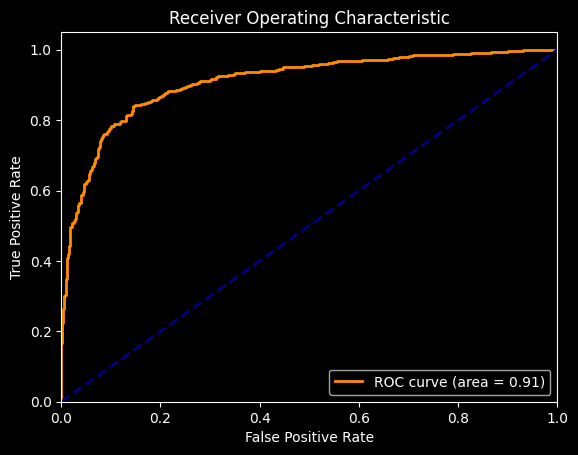

In [63]:
# Assuming 'predictions' from trainer.predict contains probabilities for each class
probabilities = predictions.predictions
# Extract probabilities for the positive class ('Paraphrase (1)')
positive_probabilities = probabilities[:, 1]
# Create the ROC curve
fpr, tpr, thresholds = roc_curve(test_dataset['label'], positive_probabilities)
# Calculate the AUC
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

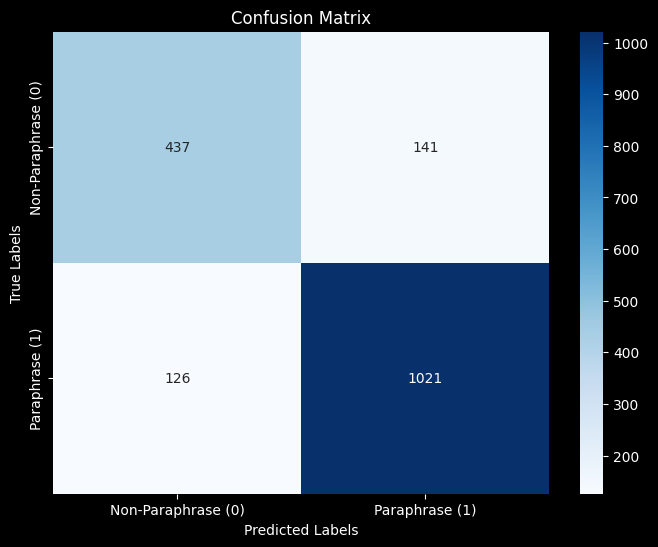

In [64]:
# Compute the confusion matrix
true_labels = test_dataset["labels"]
cm = confusion_matrix(true_labels, predicted_labels)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Paraphrase (0)', 'Paraphrase (1)'],
            yticklabels=['Non-Paraphrase (0)', 'Paraphrase (1)'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [65]:
# Extract TP, TN, FP, FN from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 1021
True Negatives (TN): 437
False Positives (FP): 141
False Negatives (FN): 126


In [66]:
# Print the classification report
print("Classification Report :\n",classification_report(true_labels, predicted_labels, target_names=['Non-Paraphrase (0)', 'Paraphrase (1)']))

Classification Report :
                     precision    recall  f1-score   support

Non-Paraphrase (0)       0.78      0.76      0.77       578
    Paraphrase (1)       0.88      0.89      0.88      1147

          accuracy                           0.85      1725
         macro avg       0.83      0.82      0.83      1725
      weighted avg       0.84      0.85      0.84      1725



<a id="8"></a>

<h1><b><p style="background-image: url(https://i.postimg.cc/0Qwf8YX6/2927262.jpg);font-family:camtasia;font-size:110%;color:white;text-align:center;border-radius:15px 50px; padding:7px; border:solid 2px #09375b; box-shadow: 20px 10px 10px #042b4c">Predictive for Test</p></b></h1>

In [67]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ahmed792002/Finetuning_XLNET_Paraphrase_Classification")
model = AutoModelForSequenceClassification.from_pretrained("ahmed792002/Finetuning_XLNET_Paraphrase_Classification")

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

In [68]:
def make_inference(sentence1, sentence2,label=-1):
    # Set device to match model's device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move model to the correct device
    model.to(device)
    # Tokenize the input sentences
    inputs = tokenizer(sentence1, sentence2, return_tensors="pt",max_length=100,truncation=True, padding="max_length")
    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}
    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
    target_names=['Non-Paraphrase (0)', 'Paraphrase (1)']
    print("Sentence1 : ",sentence1)
    print("Sentence2 : ",sentence2)
    print("\n","*"*10,"\n")
    if label != -1:
      print("Actual Output : ",target_names[label])
    print("Output : ",target_names[predicted_class])

In [69]:
sentence1 , sentence2 , label = test_dataset["sentence1"][1000],test_dataset["sentence2"][1000],test_dataset["label"][1000]
prediction = make_inference(sentence1, sentence2,label)
prediction


Sentence1 :  Intel sells the current top Pentium for US $ 637 in quantities of 1,000 .
Sentence2 :  Intel 's current Pentium 4 chips have 512K bytes of cache .

 ********** 

Actual Output :  Non-Paraphrase (0)
Output :  Non-Paraphrase (0)


In [70]:
sentence1 , sentence2 , label = test_dataset["sentence1"][500],test_dataset["sentence2"][500],test_dataset["label"][500]
prediction = make_inference(sentence1, sentence2,label)
prediction

Sentence1 :  The European Union was due Monday to demand Iran accept " urgently and unconditionally " tougher nuclear inspections and to link compliance with a pending trade deal .
Sentence2 :  The European Union was due on Monday to demand that Iran accept " urgently and unconditionally " tougher inspections of its nuclear program , linking compliance to a pending trade deal .

 ********** 

Actual Output :  Paraphrase (1)
Output :  Paraphrase (1)


In [71]:
sentence1 , sentence2 , label = test_dataset["sentence1"][50],test_dataset["sentence2"][50],test_dataset["label"][50]
prediction = make_inference(sentence1, sentence2,label)
prediction

Sentence1 :  The procedure is generally performed in the second or third trimester .
Sentence2 :  The technique is used during the second and , occasionally , third trimester of pregnancy .

 ********** 

Actual Output :  Paraphrase (1)
Output :  Paraphrase (1)


In [72]:
# Example usage
sentence1 = "Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence."
sentence2 = "Referring to him as only 'the witness', Amrozi accused his brother of deliberately distorting his evidence."
prediction = make_inference(sentence1, sentence2)
prediction

Sentence1 :  Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence.
Sentence2 :  Referring to him as only 'the witness', Amrozi accused his brother of deliberately distorting his evidence.

 ********** 

Output :  Paraphrase (1)


In [73]:
# Test sentences for inference
sentence1 = "Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence."
sentence2 = "The weather today is sunny with a slight chance of rain in the evening."
# Make prediction
prediction = make_inference(sentence1, sentence2)
prediction

Sentence1 :  Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence.
Sentence2 :  The weather today is sunny with a slight chance of rain in the evening.

 ********** 

Output :  Non-Paraphrase (0)


<center><span style="font-family:Palatino; font-size:22px;"><i>Like this? <span style="color:#DC143C;">Upvote and Comment!</span> </i>🌊 End</span> </center>